**Import Libraries**

In [122]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [123]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score

### 1. Load Data

In [124]:
# load data
df = pd.read_csv('../../data/H2.csv')

### 2. Handle Missing Values

In [125]:
# Handle missing values
df["Children"].fillna(0, inplace=True)  # Fill missing 'Children' with 0
df["Country"].fillna("Unknown", inplace=True)  # Fill missing 'Country' with 'Unknown'

# Drop rows where adults, babies and children are zero at the same time
df = df[(df["Adults"] != 0) | (df["Babies"] != 0) | (df["Children"] != 0)]

### 3. Remove Duplicate Rows

In [126]:
# Drop Duplicate rows
print(f"Total Number of Rows: {len(df)}")
print(f"Total Number of Rows without Duplicates: {len(df.drop_duplicates())}")

df = df.drop_duplicates()

Total Number of Rows: 79163
Total Number of Rows without Duplicates: 53274


### 4. Feature Organization and Creation

##### - Remove Directly Related Features

In [127]:
# Remove Directly Related columns with label
df = df.drop(["ReservationStatus", "ReservationStatusDate", "AssignedRoomType"], axis=1)

##### - Remove Unimportant Variables

In [128]:
# Remove Unimportant Variables
corr_matrix = df.select_dtypes(include=[np.number]).corr()
corr_matrix["IsCanceled"].abs().sort_values(ascending=False)

IsCanceled                     1.000000
LeadTime                       0.190712
TotalOfSpecialRequests         0.164908
RequiredCarParkingSpaces       0.125475
StaysInWeekNights              0.114249
BookingChanges                 0.092143
ADR                            0.083836
ArrivalDateYear                0.083012
Adults                         0.081822
IsRepeatedGuest                0.073253
StaysInWeekendNights           0.064445
PreviousBookingsNotCanceled    0.048540
PreviousCancellations          0.039446
Children                       0.035015
Babies                         0.021490
ArrivalDateWeekNumber          0.009155
DaysInWaitingList              0.008544
ArrivalDateDayOfMonth          0.003940
Name: IsCanceled, dtype: float64

In [129]:
df = df.drop(
    [
        "ArrivalDateDayOfMonth",
        "ArrivalDateWeekNumber",
    ],
    axis=1,
)

##### - Correct and Reorganize some features

In [130]:
# Define a dictionary to map country codes to regions
country_to_region = {
    "PRT": "Europe",
    "GBR": "Europe",
    "ESP": "Europe",
    "IRL": "Europe",
    "NLD": "Europe",
    "RUS": "Europe",
    "FRA": "Europe",
    "DEU": "Europe",
    "ITA": "Europe",
    "BEL": "Europe",
    "CHE": "Europe",
    "USA": "North America",
    "CAN": "North America",
    "MEX": "North America",
    "CN": "Asia",
    "BRA": "South America",
    "ARG": "South America",
    "AUS": "Oceania",
    "Unknown": "Unknown",
}

# Map the country codes to regions
df["Region"] = df["Country"].map(country_to_region)

# Drop the Country column
df.drop(columns=["Country"], inplace=True)

df["Region"].value_counts()

Region
Europe           41651
South America     1734
North America     1481
Asia               491
Oceania            292
Unknown              3
Name: count, dtype: int64

In [131]:
# Remove blank spaces from the 'Agent' column
df['Agent'] = df['Agent'].str.strip()

# Replace 'NULL' values in the 'Agent' column with 0
df['Agent'].replace('NULL', 0, inplace=True)

# Convert the 'Agent' column to integer
df['Agent'] = df['Agent'].astype(int)

df['Agent'].value_counts()

Agent
9      28715
0       5543
14      3342
7       3294
28      1493
       ...  
388        1
480        1
464        1
476        1
449        1
Name: count, Length: 224, dtype: int64

In [132]:
# Remove blank spaces from the 'Agent' column
df['Company'] = df['Company'].str.strip()

# Replace 'NULL' values in the 'Agent' column with 0
df['Company'].replace('NULL', 0, inplace=True)

# Convert the 'Agent' column to integer
df['Company'] = df['Company'].astype(int)

df['Company'].value_counts()

Company
0      50509
40       845
45       237
153      205
219      131
       ...  
481        1
494        1
491        1
421        1
497        1
Name: count, Length: 204, dtype: int64

### 5. Split the Data

In [133]:
from sklearn.model_selection import train_test_split

# Split data to features and target
X = df.drop("IsCanceled", axis=1)
y = df["IsCanceled"]

# Stratified splitting into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

# Check the resulting split sizes and class distribution in both sets
train_size = X_train.shape[0]
test_size = X_test.shape[0]
train_class_distribution = y_train.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)

train_size, test_size, train_class_distribution, test_class_distribution

(42619,
 10655,
 IsCanceled
 0    0.699007
 1    0.300993
 Name: proportion, dtype: float64,
 IsCanceled
 0    0.699015
 1    0.300985
 Name: proportion, dtype: float64)

### 7. Create Data Preprocessing Pipeline

In [134]:
# Custom transformers for feature engineering
def add_group_type(data):
    def determine_group_type(row):
        if row["Adults"] == 1 and (row["Children"] + row["Babies"] == 0):
            return "Single"
        elif row["Adults"] == 2 and (row["Children"] + row["Babies"] == 0):
            return "Couple"
        elif (row["Children"] + row["Babies"]) > 0:
            return "Family"
        elif row["Adults"] > 2:
            return "Big_Group"
        else:
            return "Other"

    data["GroupType"] = data.apply(determine_group_type, axis=1)
    return data


def add_booking_urgency(data):
    def determine_booking_urgency(lead_time):
        if lead_time > 60:
            return "Early_Booking"
        elif 30 <= lead_time <= 60:
            return "Medium_Term_Booking"
        else:
            return "Last_Minute_Booking"

    data["BookingUrgency"] = data["LeadTime"].apply(determine_booking_urgency)
    return data


def add_high_demand(data):
    data["HighDemand"] = data["TotalOfSpecialRequests"].apply(
        lambda x: "High" if x >= 2 else "Low"
    )
    return data


def add_child_ratio(data):
    data["ChildRatio"] = (data["Children"] + data["Babies"]) / (
        data["Adults"] + data["Children"] + data["Babies"]
    )
    data["ChildRatio"].fillna(0, inplace=True)
    return data


def add_waiting_time_category(data):
    def determine_waiting_time_category(days):
        if days < 7:
            return "Short"
        elif 7 <= days <= 30:
            return "Medium"
        else:
            return "Long"

    data["WaitingTimeCategory"] = data["DaysInWaitingList"].apply(
        determine_waiting_time_category
    )
    return data


# Pipeline for feature engineering
feature_engineering_pipeline = Pipeline(
    steps=[
        ("add_group_type", FunctionTransformer(add_group_type)),
        ("add_booking_urgency", FunctionTransformer(add_booking_urgency)),
        ("add_high_demand", FunctionTransformer(add_high_demand)),
        ("add_child_ratio", FunctionTransformer(add_child_ratio)),
        ("add_waiting_time_category", FunctionTransformer(add_waiting_time_category))
    ]
)

# Categoric and Numeric features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Final pipeline with feature engineering, preprocessing and smote
final_pipeline = Pipeline(
    steps=[
        ("feature_engineering", feature_engineering_pipeline),
        ("preprocessing", preprocessor),
    ]
)

### 8. Train Random Forest Model

##### - Train

In [135]:
# Instantiate the classifier
rf = RandomForestClassifier(random_state=42)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessing", final_pipeline),
        ("classifier", rf),
    ]
)

rf_pipeline.fit(X_train, y_train)

# Predict the labels
y_pred = rf_pipeline.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.797653683716565

##### - Evaluate

In [136]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[6728,  720],
       [1436, 1771]])

In [137]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      7448
           1       0.71      0.55      0.62      3207

    accuracy                           0.80     10655
   macro avg       0.77      0.73      0.74     10655
weighted avg       0.79      0.80      0.79     10655



In [138]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

np.float64(0.7277796254634984)

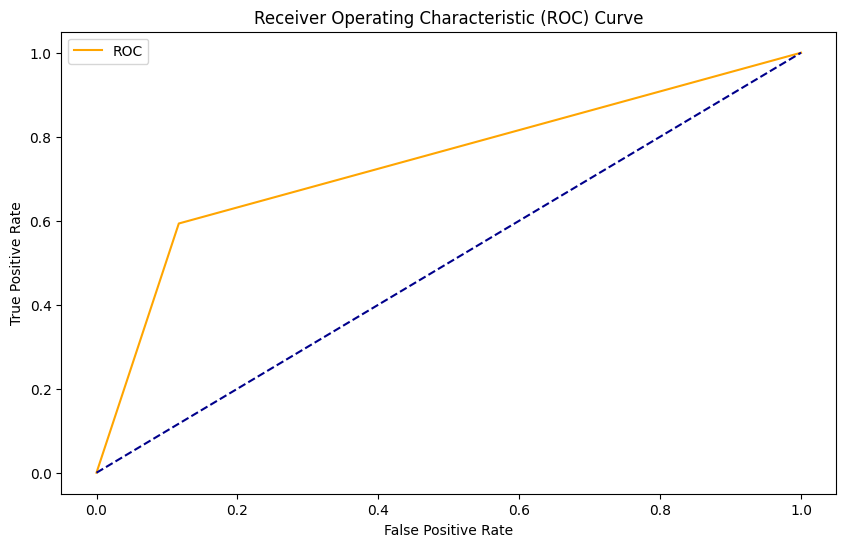

In [146]:
# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [140]:
# Perform 5-fold cross validation
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='accuracy')
cv_scores

array([0.7930549 , 0.79622243, 0.79845143, 0.79317222, 0.79432125])

In [141]:
# Calculate the mean accuracy
cv_mean = cv_scores.mean()
cv_mean

np.float64(0.7950444467679115)

In [142]:
# Calculate the standard deviation of accuracy
cv_std = cv_scores.std()
cv_std

np.float64(0.0020484980473269624)

---

Let's use Smote within and see what'll happen

In [145]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Feature engineering adımları (düzgün bir şekilde entegre edildi)
def feature_engineering(data):
    data = add_group_type(data)
    data = add_booking_urgency(data)
    data = add_high_demand(data)
    data = add_child_ratio(data)
    data = add_waiting_time_category(data)
    return data

# Preprocessing adımları
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Nihai Pipeline (feature engineering ve preprocessing ayrı)
rf_pipeline_with_smote = ImbPipeline(
    steps=[
        ("feature_engineering", FunctionTransformer(feature_engineering, validate=False)),  # Feature engineering fonksiyonu
        ("preprocessing", preprocessor),  # Preprocessing adımı
        ("smote", SMOTE(random_state=42)),  # SMOTE
        ("classifier", RandomForestClassifier(random_state=42)),  # Model
    ]
)

# Modeli eğit
rf_pipeline_with_smote.fit(X_train, y_train)

# Tahmin yap
y_pred = rf_pipeline_with_smote.predict(X_test)

# Doğruluk
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Cross-validation
cv_scores = cross_val_score(rf_pipeline_with_smote, X_train, y_train, cv=5, scoring='accuracy')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

Accuracy: 0.7959643359924918
CV Scores: [0.78742374 0.79446269 0.7952839  0.78789301 0.78892409]
Mean CV Accuracy: 0.7907974876604356
